### Predicting HDB Prices with Multivariate Linear Regression

In this notebook, we will be training a Dense Neural Network to predict HDB prices. 

#### Brief Recap of Dense Neural Networks
- **Basic Structure**
  - Composed of layers of neurons (or nodes).
  - Each neuron in a layer is connected to every neuron in the previous and following layers.
- **Layers**
  - Input Layer: Receives the input data.
  - Hidden Layers: One or more layers - where most of the computation occurs.
  - Output Layer: Produces the final output, often representing classifications or predictions.
- **Neurons**
  - Each neuron computes a weighted sum of its inputs, adds a bias, and applies an activation function.
- **Weights and Biases**
  - Weights determine the strength of the connection between neurons.
  - Biases allow the model to shift the activation function to fit the data better.
- **Activation Functions**
  - Non-linear functions like ReLU, Sigmoid, or Tanh provide non-linear properties to the network, enabling it to learn complex patterns.
  - ReLu used most often
- **Training**
  - Involves adjusting weights and biases based on a loss function using techniques like backpropagation and gradient descent.
  - Backpropagation calculates the gradient of the loss function with respect to each weight by the chain rule.
- **Overfitting and Regularization**
  - Dense networks are prone to overfitting, especially with many parameters.
  - Regularization techniques like dropout, L1/L2 regularization are used to prevent overfitting.
- **Applications**
  - Suitable for tabular data, image recognition, language processing, and many other tasks within machine learning.
- **Advantages**
  - Simple architecture easy to understand and implement.
  - Effective in capturing complex relationships in data.
- **Limitations**
  - Can become computationally intensive with large datasets.
  - Not inherently suited for spatial and sequential data (like images and time series), where convolutional and recurrent neural networks are more efficient.
  - Dense Neural Networks serve as a foundational concept in understanding more complex neural network architectures and their applications.

#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Train Test Split
from sklearn.model_selection import train_test_split, cross_validate

# Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Model Evaluation
from sklearn.metrics import mean_absolute_error, r2_score
import scipy.stats as stats


#### Load data into DataFrame and Remove Unwanted Columns

In [2]:
# Make file path variable so that all we need is to change this if we move notebook location
file_path = '../data/processed/final_HDB_for_model.parquet.gzip'

# Read data into csv
df = pd.read_parquet(file_path)

# Check to see if it loaded correctly
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890376 entries, 0 to 890375
Data columns (total 27 columns):
 #   Column                                                                         Non-Null Count   Dtype         
---  ------                                                                         --------------   -----         
 0   town                                                                           890376 non-null  object        
 1   flat_type                                                                      890376 non-null  object        
 2   block                                                                          890376 non-null  object        
 3   street_name                                                                    890376 non-null  object        
 4   storey_range                                                                   890376 non-null  object        
 5   floor_area_sqm                                                          

In [3]:
# Put all columns to be deleted into a list
drop_cols = ['block', 'street_name','address','sold_year_month']

# Drop columns
df = df.drop(columns=drop_cols)


#### Make List of Columns Based on Type

In [4]:
# Create lists of the categorical and numerical columns allowing them to be treated differently
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['floor_area_sqm', 'lease_commence_date', 'resale_price', 'sold_year',
       'sold_remaining_lease', 'max_floor_lvl', '5 year bond yields',
       'GDPm (Current Prices)', 'GDP per capita', 'Personal Income m',
       'Unemployment Rate', 'Core inflation', 'Median Household Inc',
       'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials',
       'Clay Construction Materials & Refractory Construction Materials',
       'walking_time_mrt', 'ResidentPopulation',
       'ResidentPopulation_Growth_Rate'],
      dtype='object')

In [5]:
# Remove target column from the list of columns to scale
num_cols_scale = ['floor_area_sqm', 'lease_commence_date', 'sold_year',
       'sold_remaining_lease', 'max_floor_lvl', '5 year bond yields',
       'GDPm (Current Prices)', 'GDP per capita', 'Personal Income m',
       'Unemployment Rate', 'Core inflation', 'Median Household Inc',
       'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials',
       'Clay Construction Materials & Refractory Construction Materials',
       'walking_time_mrt', 'ResidentPopulation',
       'ResidentPopulation_Growth_Rate']


#### Train Test Split

In [6]:
#select target colummn
target_col = 'resale_price'

# Ready X and y
X = df.loc[:, ~df.columns.isin([target_col])]
y = df[target_col]


In [7]:
# Split the data, 80-20 split with a random state included for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 54)


#### Creating a Pipeline 
Pipelines in machine learning are useful because they streamline the entire process of preparing data and building models. Most importantly, they make things repeatable without human error! 

In [8]:
# Create instances of OneHotEncoder and StandardScaler
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
num_standard_transformer = StandardScaler()

# Create a pipeline to apply transformation
prepoc = make_column_transformer(
    (cat_transformer, cat_cols),
    (num_standard_transformer, num_cols_scale),
    remainder='passthrough'
)

# View Pipeline
prepoc

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object')),
                                ('standardscaler', StandardScaler(),
                                 ['floor_area_sqm', 'lease_commence_date',
                                  'sold_year', 'sold_remaining_lease',
                                  'max_floor_lvl', '5 year bond yields',
                                  'GDPm (Current Prices)', 'GDP per capita',
                                  'Personal Income m', 'Unemployment Rate',
                                  'Core inflation', 'Median Household Inc',
                                  'Lime, Cement, & Fabricated Construction '
                                  'Materials Excl Glass & Clay Materials',
                                  'Clay Construction Materials & Refractory '
                                  'Construction Materials',
                                  'walking_time_mrt', 'ResidentPopulation',
                                  'ResidentPopulation_Growth_Rate'])])

#### Preprocess Training Data

In [9]:
X_train_processed = prepoc.fit_transform(X_train)
X_test_processed = prepoc.transform(X_test)


#### Create Simple DNN Model
- We will be stacking layers to create a simple model to begin with 
- The number of features in the training data (X_train_processed) will specify the input shape for the first layer of the model.
- The first layer to the model will have 20 neurons, second 10, and third only 1 as this is a regression problem.  
- Using a linear activation function for the final layer is standard practice in regression models where the output is a single continuous value.
- Aadam as the optimizer, since is is known for its efficiency in handling sparse gradients and adaptive learning rates.
- Loss function is 'mae' (Mean Absolute Error)
- Scored with R2

In [10]:
# Model instantiating
model = Sequential()

# Set input dimension
input_dim = X_train_processed.shape[1]

# Add layers
model.add(layers.Dense(20, activation='relu', input_dim=input_dim))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

# Print a summary
model.summary()

# Compile Model with
model.compile(
    optimizer='adam',
    loss='mae',
    metrics = 'R2Score')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                3820      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4041 (15.79 KB)
Trainable params: 4041 (15.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Setting Early Stopping Criteria and Training the Model
Training a DNN for more epochs can have several advantages and disadvantages:
- Advantages:
  - Additional epochs can give a model more opportunity to learn from the data, potentially leading to a better understanding of the underlying patterns and a higher accuracy on the training data.
  - Models with a lot of parameters or those that are learning complex patterns often require more epochs to converge to an optimal set of weights.
  - More epochs can help the model's performance to stabilize, which is particularly useful if the performance is still improving (without signs of overfitting).
  - With proper regularization techniques in place, training for more epochs might help the model generalize better to new, unseen data.
- Disadvantages:
  - Training for too many epochs can lead to overfitting.
  - More epochs mean more computations, which will require more time and resources.
  - Law of Diminishing Returns - after a certain point, the improvements from additional training can become marginal or nonexistent. Further training won't lead to better results.
  - It is time-consuming to train for a high number of epochs, which can delay the deployment of the model and might not be practical in fast-paced or real-time application scenarios.




In [11]:
# Setting up early stopping
es = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    restore_best_weights=True)

# Training the model and storing fitting data into variable called history for plotting
history = model.fit(
    X_train_processed, y_train,
    validation_split = 0.3,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[es])


Epoch 1/100
15582/15582 [==============================] - 9s 574us/step - loss: 122170.8359 - r2_score: -0.1737 - val_loss: 52285.1016 - val_r2_score: 0.8113
Epoch 2/100
15582/15582 [==============================] - 9s 568us/step - loss: 44397.7852 - r2_score: 0.8592 - val_loss: 39904.2969 - val_r2_score: 0.8844
Epoch 3/100
15582/15582 [==============================] - 9s 553us/step - loss: 37940.7891 - r2_score: 0.8954 - val_loss: 36143.1172 - val_r2_score: 0.9045
Epoch 4/100
15582/15582 [==============================] - 9s 550us/step - loss: 34805.4805 - r2_score: 0.9112 - val_loss: 33484.1406 - val_r2_score: 0.9171
Epoch 5/100
15582/15582 [==============================] - 9s 585us/step - loss: 32490.9141 - r2_score: 0.9216 - val_loss: 31497.8672 - val_r2_score: 0.9261
Epoch 6/100
15582/15582 [==============================] - 9s 584us/step - loss: 30756.5566 - r2_score: 0.9292 - val_loss: 29982.7676 - val_r2_score: 0.9324
Epoch 7/100
15582/15582 [==============================]

#### Create Function to Display Model Training

In [12]:
def plot_history(history):
    # 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(13, 6))

    # First subplot for Loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='best')

    # Second subplot for R2 Score
    axs[1].plot(history.history['r2_score'], label='Train R2 Score')
    axs[1].plot(history.history['val_r2_score'], label='Validation R2 Score')
    axs[1].set_title('Model R2 Score')
    axs[1].set_ylabel('R2 Score')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='best')

    plt.tight_layout()
    plt.show()


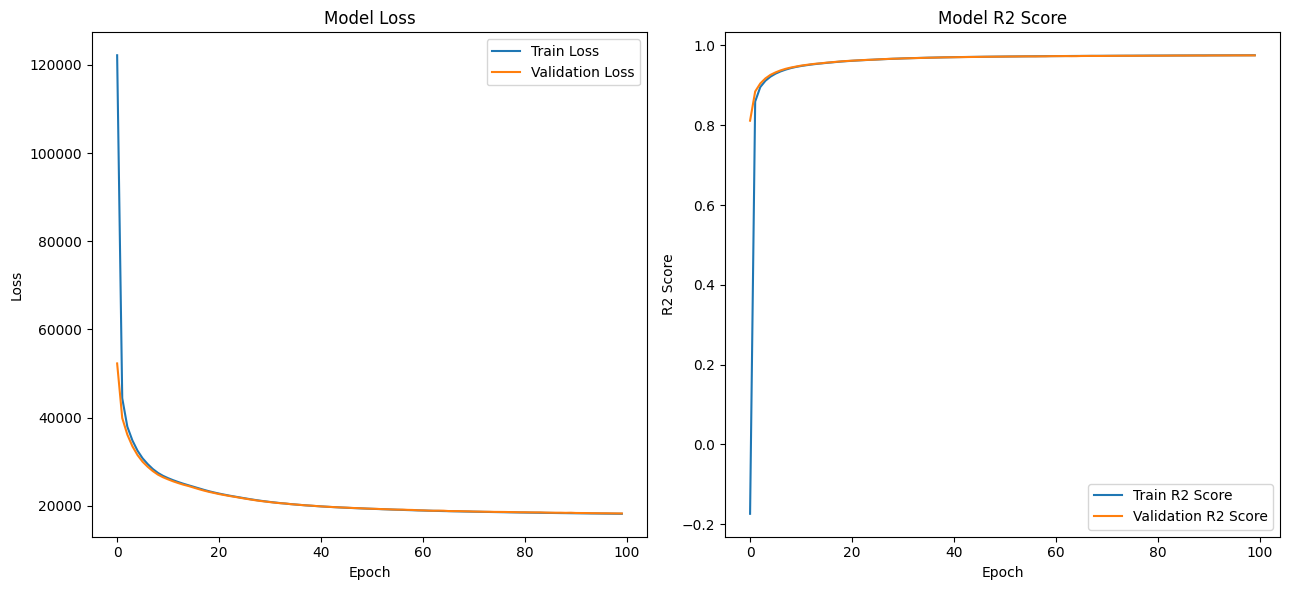

In [13]:
plot_history(history)


**Comments**
- The model appears to be learning effectively, as indicated by the decreasing loss and increasing R2 score.
- No significant divergence between the training and validation lines in either plot, which indicates no be overfitting.
- Both training and validation loss decrease sharply at the beginning and then plateau, showing minimal change with more epochs.

#### Evaluate Model on Unseen Test Set

In [14]:
model.evaluate(X_test_processed, y_test)


5565/5565 [==============================] - 2s 338us/step - loss: 18284.9297 - r2_score: 0.9750


[18284.9296875, 0.9750157594680786]

**Comments**
- The high R2 score of 0.9763 indicates that the model is performing very well on unseen data - not overfitting. 
- The MAE of 17734.24 is good as HDB prices are usually ~$500K and this was tested on 5565 samples in the unseen test set. 

#### Creating a Second DNN Model

In [15]:
# Model instantiating
model2 = Sequential()

# Add layers
model2.add(layers.Dense(20, activation='relu', input_dim=input_dim))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='linear'))

# Print a summary
model2.summary()

# Compile Model with
model2.compile(
    optimizer='adam',
    loss='mae',
    metrics = 'R2Score')

# Setting up early stopping
es = EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True)


# Training the model and storing fitting data into variable called history for plotting
history2 = model2.fit(
    X_train_processed, y_train,
    validation_split = 0.3,
    epochs=100, batch_size=32, verbose=1, callbacks=[es])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                3820      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 4091 (15.98 KB)
Trainable params: 4091 (15.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
15582/15582 [==============================] - 10s 603us/step - loss: 75359.5703 - r2_score: 0.4253 - val_loss: 39448.4375 - val_r2_score: 0

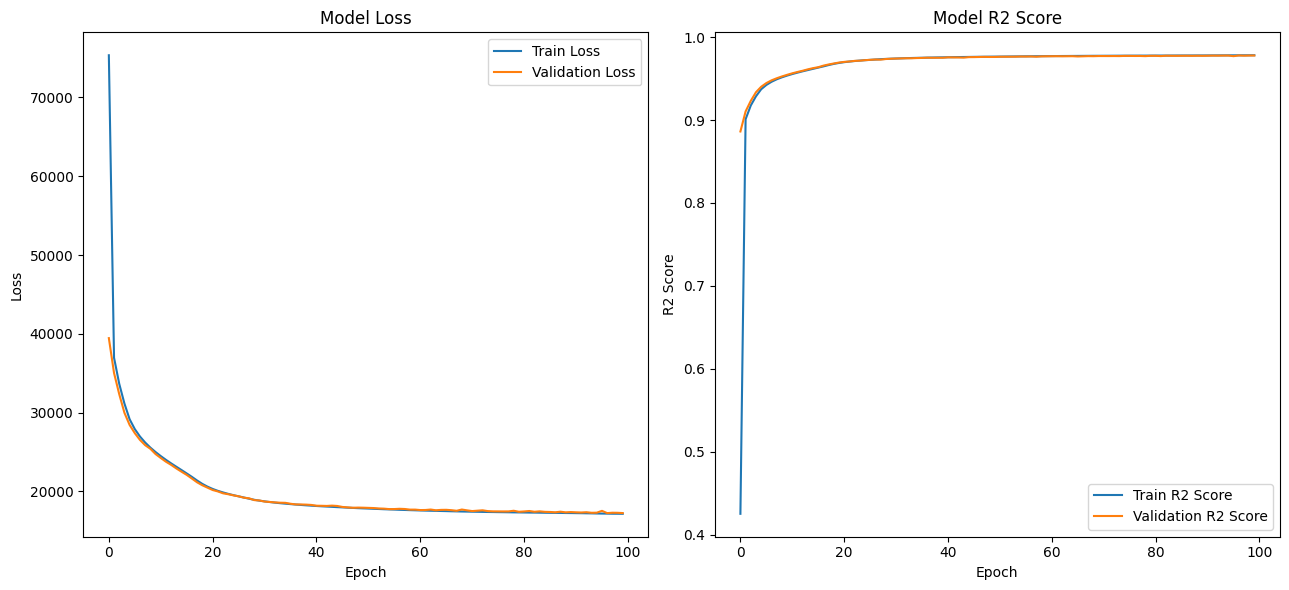

In [16]:
plot_history(history2)


**Comments**
- The model appears to be learning effectively, as indicated by the decreasing loss and increasing R2 score.
- No significant divergence between the training and validation lines in either plot, which indicates no be overfitting.
- Both training and validation loss decrease sharply at the beginning and then plateau, showing minimal change with more epochs.

#### Evaluate Model on Unseen Test Set

In [17]:
model2.evaluate(X_test_processed, y_test)


5565/5565 [==============================] - 2s 343us/step - loss: 17318.0977 - r2_score: 0.9777


[17318.09765625, 0.9776790142059326]

**Comments**
- The high R2 score of 0.9784 indicates that the model is performing very well on unseen data - not overfitting. 
- The MAE of 16943.05 is good as HDB prices are usually ~$500K and this was tested on 5565 samples in the unseen test set. 

#### Create a Full Pipeline with Model2's DNN Model Architecture 


In [18]:
#create final pipeline
pipe = make_pipeline(prepoc, model2)

pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'lease_commence_date',
                                                   's...
                                                   'Unemployment Rate',
                                                   'Core inflation',
                                                   'Median Household Inc',
                                                   'Lime, Cement, & Fabricated '
                                                   'Construction Materials '
                                                   'Excl Glass & Clay '
                                                   'Materials',
                                                   'Clay Construction '
                                                   'Materials & Refractory '
                                                   'Construction Materials',
                                                   'walking_time_mrt',
                                                   'ResidentPopulation',
                                                   'ResidentPopulation_Growth_Rate'])])),
                ('sequential',
                 <keras.src.engine.sequential.Sequential object at 0x291cd6950>)])

In [19]:
#fit model

es = EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True)

pipe.fit(
    X_train, y_train,
    sequential__validation_split = 0.3,
    sequential__epochs=100, sequential__batch_size=32, sequential__verbose=1, sequential__callbacks=[es])


Epoch 1/100
15582/15582 [==============================] - 9s 591us/step - loss: 17137.2207 - r2_score: 0.9781 - val_loss: 17233.3359 - val_r2_score: 0.9777
Epoch 2/100
15582/15582 [==============================] - 9s 587us/step - loss: 17126.5801 - r2_score: 0.9781 - val_loss: 17252.2695 - val_r2_score: 0.9778
Epoch 3/100
15582/15582 [==============================] - 9s 580us/step - loss: 17122.0566 - r2_score: 0.9781 - val_loss: 17275.0176 - val_r2_score: 0.9778
Epoch 4/100
15582/15582 [==============================] - 9s 583us/step - loss: 17115.0586 - r2_score: 0.9781 - val_loss: 17217.4551 - val_r2_score: 0.9778
Epoch 5/100
15582/15582 [==============================] - 9s 583us/step - loss: 17112.8359 - r2_score: 0.9781 - val_loss: 17219.9766 - val_r2_score: 0.9777
Epoch 6/100
15582/15582 [==============================] - 9s 582us/step - loss: 17102.3750 - r2_score: 0.9781 - val_loss: 17290.4414 - val_r2_score: 0.9778
Epoch 7/100
15582/15582 [==============================] -

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'lease_commence_date',
                                                   's...
                                                   'Unemployment Rate',
                                                   'Core inflation',
                                                   'Median Household Inc',
                                                   'Lime, Cement, & Fabricated '
                                                   'Construction Materials '
                                                   'Excl Glass & Clay '
                                                   'Materials',
                                                   'Clay Construction '
                                                   'Materials & Refractory '
                                                   'Construction Materials',
                                                   'walking_time_mrt',
                                                   'ResidentPopulation',
                                                   'ResidentPopulation_Growth_Rate'])])),
                ('sequential',
                 <keras.src.engine.sequential.Sequential object at 0x291cd6950>)])

In [21]:
import pickle

# Assuming 'model' is your trained model
with open('../models/denseNN_231214.pkl', 'wb') as file:
    pickle.dump(pipe, file)
